In [1]:
import os
import sys

def add_to_sys_path(relative_path):
    abs_path = os.path.abspath(os.path.join(os.getcwd(), relative_path))
    if abs_path not in sys.path:
        sys.path.append(abs_path)

add_to_sys_path(os.path.join('..', '..', '..', 'Utils'))
add_to_sys_path(os.path.join('..', '..', '..', 'Model'))
add_to_sys_path(os.path.join('..', '..', '..', 'alg'))
add_to_sys_path(os.path.join('..', '..', '..', 'Scaffolding_OOD'))

In [2]:
import pandas as pd
import numpy as np
import random
import shap

from sklearn.impute import SimpleImputer

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier

from LR import base_model as base_model_call
from model_data_processing import Data_Handler, Model_Metrics_Visualizer

/home/jn/anaconda3/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [3]:
# Import modules for the attack
from config import (
    RANDOM_SEED, N_SAMPLES_DATA, BIAS_CORRELATION_STRENGTH, POSITIVE_OUTCOME,
    TEST_SIZE, LIME_PERTURBATION_STD, LIME_PERTURBATION_MULTIPLIER,
    SHAP_N_SAMPLES_OOD, SHAP_N_KMEANS_BACKGROUND, OOD_PRED_THRESHOLD,
    UNPROTECTED_CLASS_VALUE, PROTECTED_CLASS_VALUE
)
from data_handler import generate_base_data, process_data
from bias_injector import add_highly_correlated_biased_feature
from ood_generator import generate_lime_style_ood, generate_shap_style_ood, combine_ood_data_for_detector_training
from ood_detector import OODDetector
from scaffold_model import Adversarial_Lime_Model, Adversarial_Kernel_SHAP_Model, CombinedAdversarialModel
from explainer_helper import get_lime_explanation, get_shap_explanation, print_explanation, plot_explanation_comparison, get_feature_rank_frequencies, plot_feature_rank_distribution

In [4]:
data = pd.read_csv('../../../Dataset/cybersecurity_intrusion_data.csv')
# data = data.drop(columns=['Unnamed: 0.1', 'Unnamed: 0', 'uid', 'originh', 'responh'])
data.head()

,session_id,network_packet_size,protocol_type,login_attempts,session_duration,encryption_used,ip_reputation_score,failed_logins,browser_type,unusual_time_access,attack_detected
0,SID_00001,599,TCP,4,492.983263,DES,0.606818,1,Edge,0,1
1,SID_00002,472,TCP,3,1557.996461,DES,0.301569,0,Firefox,0,0
2,SID_00003,629,TCP,3,75.044262,DES,0.739164,2,Chrome,0,1
3,SID_00004,804,UDP,4,601.248835,DES,0.123267,0,Unknown,0,1
4,SID_00005,453,TCP,5,532.540888,AES,0.054874,1,Firefox,0,0


In [5]:
has_failed_logins = []
for i in data['failed_logins']:
    if i:
        has_failed_logins.append(1)
    else:
        has_failed_logins.append(0)

data['has_failed_logins'] = has_failed_logins

In [6]:
data['protocol_type'] = data['protocol_type'].replace({'ICMP': 0, 'TCP': 1, 'UDP': 2})
data['encryption_used'] = data['encryption_used'].replace({'AES': 0, 'DES': 1})
data['encryption_used'] = data['encryption_used'].fillna(3)

In [7]:
data['encryption_used'].value_counts()

encryption_used
0.0    4706
1.0    2865
3.0    1966
Name: count, dtype: int64

In [8]:
# positive outcome is set to 1, so we have to make sure that non-attack is our expected output, and protected feature is biased for that
data['attack_detected'] = data['attack_detected'].replace({0: 1, 1: 0})

In [9]:
data = data.drop(data.select_dtypes(include='object').columns, axis=1)
data.head()

,network_packet_size,protocol_type,login_attempts,session_duration,encryption_used,ip_reputation_score,failed_logins,unusual_time_access,attack_detected,has_failed_logins
0,599,1,4,492.983263,1.0,0.606818,1,0,0,1
1,472,1,3,1557.996461,1.0,0.301569,0,0,1,0
2,629,1,3,75.044262,1.0,0.739164,2,0,0,1
3,804,2,4,601.248835,1.0,0.123267,0,0,0,0
4,453,1,5,532.540888,0.0,0.054874,1,0,1,1


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9537 entries, 0 to 9536
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   network_packet_size  9537 non-null   int64  
 1   protocol_type        9537 non-null   int64  
 2   login_attempts       9537 non-null   int64  
 3   session_duration     9537 non-null   float64
 4   encryption_used      9537 non-null   float64
 5   ip_reputation_score  9537 non-null   float64
 6   failed_logins        9537 non-null   int64  
 7   unusual_time_access  9537 non-null   int64  
 8   attack_detected      9537 non-null   int64  
 9   has_failed_logins    9537 non-null   int64  
dtypes: float64(3), int64(7)
memory usage: 745.2 KB


In [11]:
len(data)

9537

In [12]:
protected_feature = 'has_failed_logins'

In [13]:
data.head()

,network_packet_size,protocol_type,login_attempts,session_duration,encryption_used,ip_reputation_score,failed_logins,unusual_time_access,attack_detected,has_failed_logins
0,599,1,4,492.983263,1.0,0.606818,1,0,0,1
1,472,1,3,1557.996461,1.0,0.301569,0,0,1,0
2,629,1,3,75.044262,1.0,0.739164,2,0,0,1
3,804,2,4,601.248835,1.0,0.123267,0,0,0,0
4,453,1,5,532.540888,0.0,0.054874,1,0,1,1


In [14]:
# biased_data = add_highly_correlated_biased_feature(
#         data,
#         target_column='Label',
#         new_feature_name=protected_feature,
#         correlation_strength=BIAS_CORRELATION_STRENGTH,
#         favor_outcome=POSITIVE_OUTCOME # The protected group (value 1) will be favored for POSITIVE_OUTCOME (value 1)
#     )

biased_data = data.copy()

In [15]:
biased_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9537 entries, 0 to 9536
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   network_packet_size  9537 non-null   int64  
 1   protocol_type        9537 non-null   int64  
 2   login_attempts       9537 non-null   int64  
 3   session_duration     9537 non-null   float64
 4   encryption_used      9537 non-null   float64
 5   ip_reputation_score  9537 non-null   float64
 6   failed_logins        9537 non-null   int64  
 7   unusual_time_access  9537 non-null   int64  
 8   attack_detected      9537 non-null   int64  
 9   has_failed_logins    9537 non-null   int64  
dtypes: float64(3), int64(7)
memory usage: 745.2 KB


Injecting deliberatly some synthetic ood data, if want to go witht the original dataset, just comment out the segment

In [16]:
# # Configuration - OOD samples will be 20% of original data size
# ood_ratio = 0.20
# n_ood = int(len(biased_data) * ood_ratio)

# # Identify integer columns (excluding Label)
# int_cols = [col for col in biased_data.columns 
#             if col != 'Label' and biased_data[col].dtype in ['int64', 'int32']]

# # Handle NaN values while preserving integer types
# for col in biased_data.columns:
#     if col == 'Label':
#         continue
#     if col in int_cols:
#         # For integer columns, fill with rounded median to maintain integers
#         biased_data[col] = biased_data[col].fillna(round(biased_data[col].median())).astype(int)
#     else:
#         # For non-integer columns, use mean
#         biased_data[col] = biased_data[col].fillna(biased_data[col].mean())

# X_clean = biased_data.drop(columns='Label').values
# y_clean = biased_data['Label'].values

# # Train KNN on clean data
# knn = KNeighborsClassifier(n_neighbors=3).fit(X_clean, y_clean)

# # Generate LIME-style OOD (50% of OOD samples)
# lime_samples = X_clean[np.random.choice(len(X_clean), size=n_ood//2, replace=True)]
# X_lime, _ = generate_lime_style_ood(lime_samples, feature_names=biased_data.columns.tolist()[1:])
# lime_labels = knn.predict(X_lime)

# # Generate SHAP-style OOD (remaining 50%)
# shap_samples = X_clean[np.random.choice(len(X_clean), size=n_ood//2, replace=True)]
# X_shap, _ = generate_shap_style_ood(shap_samples, feature_names=biased_data.columns.tolist()[1:])
# shap_labels = knn.predict(X_shap)

# # Directly extend biased_data (no new variables created)
# biased_data = pd.concat([
#     biased_data,
#     pd.DataFrame(X_lime, columns=biased_data.columns.tolist()[1:]).assign(Label=lime_labels),
#     pd.DataFrame(X_shap, columns=biased_data.columns.tolist()[1:]).assign(Label=shap_labels)
# ], ignore_index=True)

# # Convert integer columns back to integers (in case generation created floats)
# for col in int_cols:
#     biased_data[col] = biased_data[col].astype(int)

# print(f"Extended dataset size: {len(biased_data)}")
# print("New label distribution:\n", biased_data['Label'].value_counts())

In [ ]:
x_train, x_test, y_train, y_test, feature_names, scaler = Data_Handler(
        df=biased_data,
        target_column='attack_detected',
        protected_feature=protected_feature,
        do_scaling=True,
        correlation_threshold=0.35,
        test_size=0.3,
        random_state=0
    )


Applying feature correlation removal...
Scaling numerical features: ['network_packet_size', 'login_attempts', 'session_duration', 'ip_reputation_score', 'failed_logins']


In [18]:
print(len(x_train.columns))
x_train.head()

9


,network_packet_size,protocol_type,login_attempts,session_duration,encryption_used,ip_reputation_score,failed_logins,unusual_time_access,has_failed_logins
4521,1.070864,1,1.484552,-0.300794,1.0,-0.038904,0.461359,0,1
8445,-0.860225,1,2.492526,-0.940790,3.0,-1.298406,0.461359,0,1
9438,0.825089,2,1.988539,-0.342331,1.0,-1.479774,0.461359,0,1
2357,0.137923,1,0.476579,0.587420,0.0,0.025405,-0.507364,0,1
5798,0.509093,1,-0.531395,-0.324137,1.0,-0.488635,-0.507364,0,1


In [19]:
feature_names

['network_packet_size',
 'protocol_type',
 'login_attempts',
 'session_duration',
 'encryption_used',
 'ip_reputation_score',
 'failed_logins',
 'unusual_time_access',
 'has_failed_logins']

Accuracy: 0.7431865828092243
Precision: 0.743960663751687
Recall: 0.7431865828092243
F-1: 0.7405130450407302


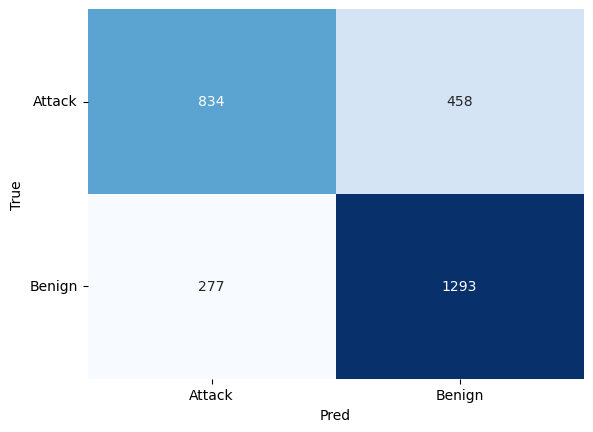

In [20]:
# With the protected feature
f_obscure = base_model_call(x_train, y_train, protected_feature, True)
y_pred_f_obscure = f_obscure.predict(x_test)
Model_Metrics_Visualizer(y_test, y_pred_f_obscure)

Accuracy: 0.7260656883298393
Precision: 0.725909936848855
Recall: 0.7260656883298393
F-1: 0.7236657837691527


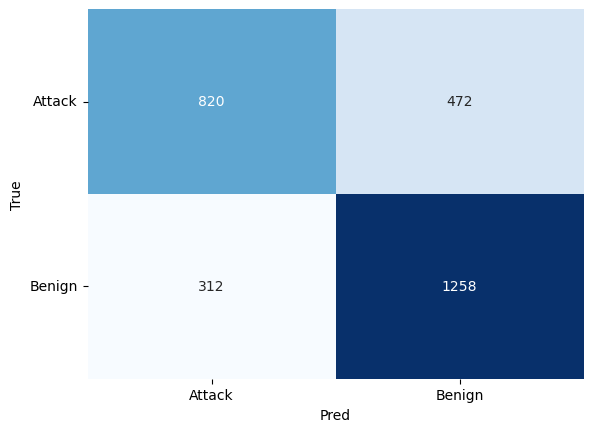

In [21]:
# Without the protected feature
psi_display = base_model_call(x_train, y_train, protected_feature, False)
y_pred_psi_display = psi_display.predict(x_test)
Model_Metrics_Visualizer(y_test, y_pred_psi_display)

In [22]:
# adv_lime_model = Adversarial_Lime_Model(f_obscure, psi_display, perturbation_std=LIME_PERTURBATION_STD)
# adv_lime_model.train(x_train, feature_names, perturbation_multiplier=LIME_PERTURBATION_MULTIPLIER)
adv_lime_model = CombinedAdversarialModel(f_obscure, psi_display)
adv_lime_model.train(x_train, feature_names)
print(f"Adversarial LIME Model fidelity on test set: {adv_lime_model.fidelity(x_test):.4f}")
print(f"Adversarial LIME Model accuracy on test set: {adv_lime_model.score(x_test, y_test):.4f}")

--- OOD Generator: Generating LIME-style OOD data ---
Generated 6675 LIME-style OOD samples (equal to in-distribution samples).
--- OOD Detector: Training detector ---


OOD Detector training complete. Accuracy: 0.9996
OOD Detector Classification Report (1: In-Dist, 0: OOD):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1335
           1       1.00      1.00      1.00      1335

    accuracy                           1.00      2670
   macro avg       1.00      1.00      1.00      2670
weighted avg       1.00      1.00      1.00      2670

--- OOD Generator: Generating SHAP-style OOD data ---

Generated 6675 SHAP-style OOD samples (equal to in-distribution samples).
--- OOD Detector: Training detector ---
OOD Detector training complete. Accuracy: 0.9004
OOD Detector Classification Report (1: In-Dist, 0: OOD):
               precision    recall  f1-score   support

           0       0.90      0.90      0.90      1335
           1       0.90      0.90      0.90      1335

    accuracy                           0.90      2670
   macro avg       0.90      0.90      0.90      2670
weighted avg      

In [23]:
adv_lime_model.print_ood_stats(x_test)


=== Combined OOD Detection Report ===
Samples processed: 2862
LIME OOD detected: 0 (0.00%)
SHAP OOD detected: 252 (8.81%)
Combined OOD detected: 252 (8.81%)


In [24]:
# adv_shap_model = Adversarial_Kernel_SHAP_Model(f_obscure, psi_display)
# adv_shap_model.train(x_train, feature_names, n_samples=SHAP_N_SAMPLES_OOD, n_kmeans=SHAP_N_KMEANS_BACKGROUND)
adv_shap_model = CombinedAdversarialModel(f_obscure, psi_display)
adv_shap_model.train(x_train, feature_names)
print(f"Adversarial SHAP Model fidelity on test set: {adv_shap_model.fidelity(x_test):.4f}")
print(f"Adversarial SHAP Model accuracy on test set: {adv_shap_model.score(x_test, y_test):.4f}")

--- OOD Generator: Generating LIME-style OOD data ---
Generated 6675 LIME-style OOD samples (equal to in-distribution samples).
--- OOD Detector: Training detector ---
OOD Detector training complete. Accuracy: 0.9996
OOD Detector Classification Report (1: In-Dist, 0: OOD):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1335
           1       1.00      1.00      1.00      1335

    accuracy                           1.00      2670
   macro avg       1.00      1.00      1.00      2670
weighted avg       1.00      1.00      1.00      2670

--- OOD Generator: Generating SHAP-style OOD data ---

Generated 6675 SHAP-style OOD samples (equal to in-distribution samples).
--- OOD Detector: Training detector ---
OOD Detector training complete. Accuracy: 0.9004
OOD Detector Classification Report (1: In-Dist, 0: OOD):
               precision    recall  f1-score   support

           0       0.90      0.90      0.90      1335
           1 

In [25]:
adv_shap_model.print_ood_stats(x_test)


=== Combined OOD Detection Report ===
Samples processed: 2862
LIME OOD detected: 0 (0.00%)
SHAP OOD detected: 252 (8.81%)
Combined OOD detected: 252 (8.81%)


In [26]:
# Select an instance from the test set to explain
instance_to_explain_idx = 1 # Choose the first test instance
instance_to_explain = np.array(x_test.iloc[[instance_to_explain_idx]])
original_prediction = f_obscure.predict(instance_to_explain)
print(f"\nExplaining instance {instance_to_explain_idx} (true label: {y_test.iloc[instance_to_explain_idx]}, f_obscure predicts: {original_prediction})")
x_test.iloc[[instance_to_explain_idx]]



Explaining instance 1 (true label: 0, f_obscure predicts: [0])


,network_packet_size,protocol_type,login_attempts,session_duration,encryption_used,ip_reputation_score,failed_logins,unusual_time_access,has_failed_logins
1824,0.163002,1,-0.027408,0.257462,0.0,1.54642,0.461359,0,1


In [27]:
# LIME for f_obscure
lime_exp_f_obscure = get_lime_explanation(
        f_obscure,
        instance_to_explain,
        feature_names,
        x_train, # LIME explainer needs training data for background distribution
        class_names=['Benign', 'Malicious']
    )
# print_explanation(lime_exp_f_obscure, feature_names, "LIME Explanation (Original Biased Model)", predicted_class=original_prediction)

In [28]:
shap_background_f_obscure = shap.sample(x_train, 100)
shap_exp_f_obscure = get_shap_explanation(
        f_obscure,
        instance_to_explain.reshape(1, -1), # SHAP expects 2D array
        feature_names,
        shap_background_f_obscure,
        class_names=['Benign', 'Malicious'],
        explainer_type='kernel'
    )
# print_explanation(shap_exp_f_obscure, feature_names, "SHAP Kernel Explanation (Original Biased Model)", predicted_class=original_prediction)

In [29]:
# LIME for Adversarial LIME Model
lime_exp_adv_lime = get_lime_explanation(
        adv_lime_model,
        instance_to_explain,
        feature_names,
        x_train, # LIME explainer needs training data for background distribution
        class_names=['Benign', 'Malicious']
    )
# print_explanation(lime_exp_adv_lime, feature_names, "LIME Explanation (Adversarial LIME Model)", predicted_class=original_prediction)

In [30]:
# SHAP (KernelExplainer) for Adversarial SHAP Model
shap_background_adv_shap = shap.sample(x_train, 100) # Use a sample of training data for background
shap_exp_adv_shap = get_shap_explanation(
        adv_shap_model,
        instance_to_explain.reshape(1, -1), # SHAP expects 2D array
        feature_names,
        shap_background_adv_shap,
        class_names=['Benign', 'Malicious'],
        explainer_type='kernel'
    )
# print_explanation(shap_exp_adv_shap, feature_names, "SHAP Kernel Explanation (Adversarial SHAP Model)", predicted_class=original_prediction)

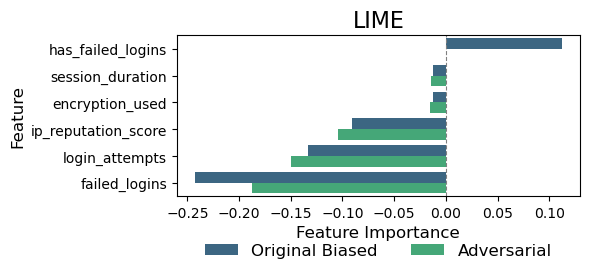

In [31]:
# Plot LIME explanations comparison
plot_explanation_comparison(
        lime_exp_f_obscure,
        lime_exp_adv_lime,
        feature_names,
        protected_feature,
        "LIME",
        predicted_class=original_prediction
    )

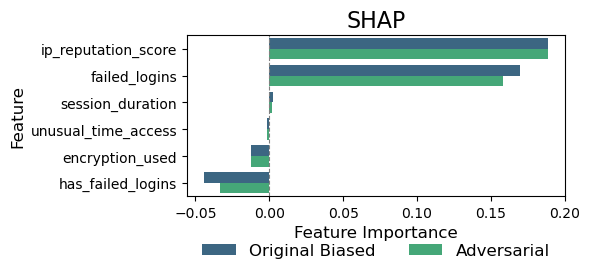

In [32]:
# Plot SHAP explanations comparison
plot_explanation_comparison(
        shap_exp_f_obscure,
        shap_exp_adv_shap,
        feature_names,
        protected_feature,
        "SHAP",
        predicted_class=original_prediction
    )

In [33]:
X_test, X_train = np.array(x_test), np.array(x_train)

In [34]:
def get_categorical_feature_indices(all_feature_names: list, numerical_feature_names: list) -> list:
    """
    Identifies categorical feature names and their indices by excluding numerical features
    from the complete list of feature names.

    Args:
        all_feature_names (list): A list containing all feature names in their original order.
        numerical_feature_names (list): A list containing the names of numerical features.

    Returns:
        list: A sorted list of integer indices corresponding to the categorical features.
    """
    # Convert numerical_feature_names to a set for efficient lookup
    numerical_features_set = set(numerical_feature_names)

    categorical_feature_names = []
    categorical_feature_indices = []

    # Iterate through all feature names to identify categorical ones
    for i, feature_name in enumerate(all_feature_names):
        if feature_name not in numerical_features_set:
            categorical_feature_names.append(feature_name)
            categorical_feature_indices.append(i)

    # Sort the indices to ensure consistent order
    categorical_feature_indices.sort()

    return categorical_feature_indices

In [35]:
# Use a sample of the test data for frequency analysis
num_instances_for_frequency_analysis = min(1000, X_test.shape[0]) # Increased sample size for better statistics
X_freq_sample = X_test[:num_instances_for_frequency_analysis]
# Get predictions for each model on the sample for correct 'predicted_class'
y_pred_freq_sample_f_obscure = f_obscure.predict(X_freq_sample)
y_pred_freq_sample_adv_lime = adv_lime_model.predict(X_freq_sample)
y_pred_freq_sample_adv_shap = adv_shap_model.predict(X_freq_sample)

# SHAP background data for frequency analysis
shap_background_freq = shap.sample(X_train, 100)

top_n_for_rank_plot = 5

lime_categorical_features_indices = get_categorical_feature_indices(x_train.columns, ['network_packet_size', 'login_attempts', 'session_duration', 'ip_reputation_score', 'failed_logins'])

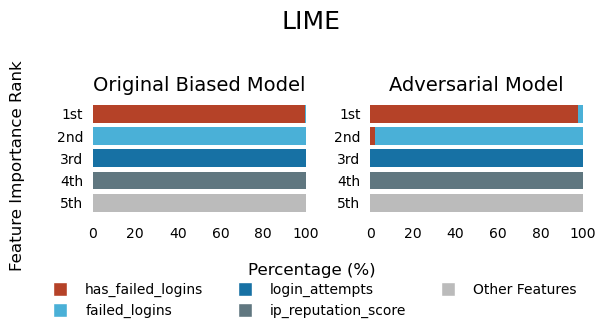

In [36]:
# --- LIME Rank Frequency Analysis ---
lime_rank_freq_data = {}
lime_rank_freq_data['Original Biased Model'] = get_feature_rank_frequencies(
        f_obscure, 'lime', X_freq_sample, feature_names, y_pred_freq_sample_f_obscure,
        X_train, None, top_n=top_n_for_rank_plot, class_names=['Benign', 'Malicious'],
        categorical_feature_indices=lime_categorical_features_indices # <--- PASS ALL CATEGORICAL INDICES
    )
lime_rank_freq_data['Adversarial Model'] = get_feature_rank_frequencies(
        adv_lime_model, 'lime', X_freq_sample, feature_names, y_pred_freq_sample_adv_lime,
        X_train, None, top_n=top_n_for_rank_plot, class_names=['Benign', 'Malicious'],
        categorical_feature_indices=lime_categorical_features_indices # <--- PASS ALL CATEGORICAL INDICES
    )

plot_feature_rank_distribution(
        lime_rank_freq_data, 'LIME', protected_feature,
        "LIME", top_n=top_n_for_rank_plot
    )

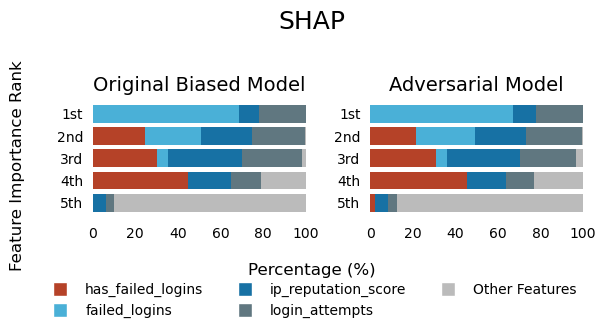

In [37]:
# --- SHAP Rank Frequency Analysis ---
shap_rank_freq_data = {}
shap_rank_freq_data['Original Biased Model'] = get_feature_rank_frequencies(
        f_obscure, 'shap', X_freq_sample, feature_names, y_pred_freq_sample_f_obscure,
        None, shap_background_freq, top_n=top_n_for_rank_plot, class_names=['Benign', 'Malicious']
    )
shap_rank_freq_data['Adversarial Model'] = get_feature_rank_frequencies(
        adv_shap_model, 'shap', X_freq_sample, feature_names, y_pred_freq_sample_adv_shap,
        None, shap_background_freq, top_n=top_n_for_rank_plot, class_names=['Benign', 'Malicious']
    )
# REMOVED: The 'Innocuous (psi)' model is no longer included in the plot data.
# shap_rank_freq_data['Innocuous (psi)'] = get_feature_rank_frequencies(
#         psi_display, 'shap', X_freq_sample, feature_names, y_pred_freq_sample_f_obscure,
#         None, shap_background_freq, top_n=top_n_for_rank_plot, class_names=['Benign', 'Malicious']
#     )

plot_feature_rank_distribution(
        shap_rank_freq_data, 'SHAP', protected_feature, # Ensure 'protected_feature' is defined in your notebook
        "SHAP", top_n=top_n_for_rank_plot
    )